In [54]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd


# Read data

In [32]:
muni = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/DTB_BRASIL_MUNICIPIO.csv',sep=';')

muni = muni[['UF', 'Nome_UF', 'Mesorregião Geográfica', 'Nome_Mesorregião',
       'Microrregião Geográfica', 'Nome_Microrregião', 'Município',
       'Código Município Completo', 'Nome_Município']]

muni = muni.assign(co_ibge6 = muni['Código Município Completo'].astype(str).str[0:6])

muni.co_ibge6 = muni.co_ibge6.astype(int)


In [9]:
mob = pd.read_parquet('/Users/julianeoliveira/Downloads/prob_spread.parquet')

In [10]:
df = pd.read_parquet('/Users/julianeoliveira/Downloads/aesop_2025_10_01_mun_withNewEnsIvas.parquet')

df = df[df.epiyear >= 2022]

In [57]:
br_munis = gpd.read_file('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Shapefiles/BR_Municipios_2022/BR_Municipios_2022.shp')

# Start descriptive

## Map of the risk probability

In [66]:
dta1 = mob.groupby(['origin_city', 'k'])['average_neighbour_level_probability'].max().reset_index()

dta1['origin_city'] = dta1['origin_city'].astype(str)

muni['Código Município Completo'] = muni['Código Município Completo'].astype(str)

dta2 = dta1[dta1.k == 0]

dta_map_risk_k0 = pd.merge(muni, dta2, left_on='Código Município Completo', right_on='origin_city', how='left')

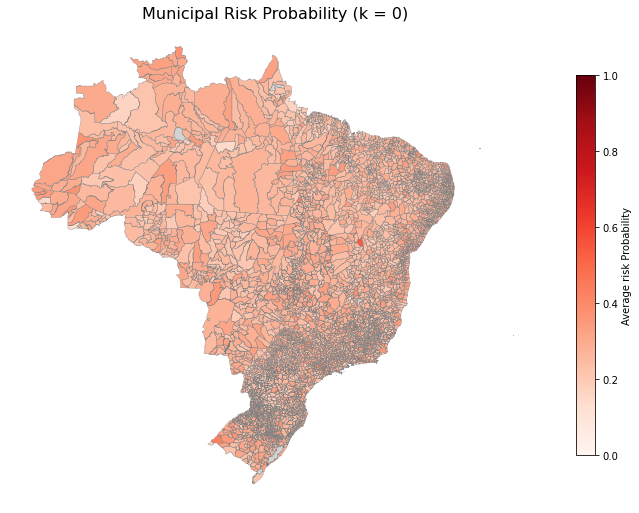

In [74]:


br_munis['CD_MUN'] = br_munis['CD_MUN'].astype(int)
dta_map_risk_k0['Código Município Completo'] = dta_map_risk_k0['Código Município Completo'].astype(int)

# Merge on IBGE code
gdf = br_munis.merge(dta_map_risk_k0, left_on='CD_MUN', right_on='Código Município Completo', how='left')

# ----------------------------
# Plot the map
# ----------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Base map with states boundaries (optional)
br_munis.boundary.plot(ax=ax, linewidth=0.3, color='grey')


# Plot municipalities with risk probability
gdf.plot(column='average_neighbour_level_probability',
         cmap='Reds',
         legend=True,
         legend_kwds={'label': "Average risk Probability", 'shrink': 0.7},
         ax=ax,
         vmin=vmin, 
         vmax=vmax,
         missing_kwds={"color": "lightgrey", "label": "No data"})

# Aesthetics
ax.set_title("Municipal Risk Probability (k = 0)", fontsize=16)
ax.axis('off')

plt.show()


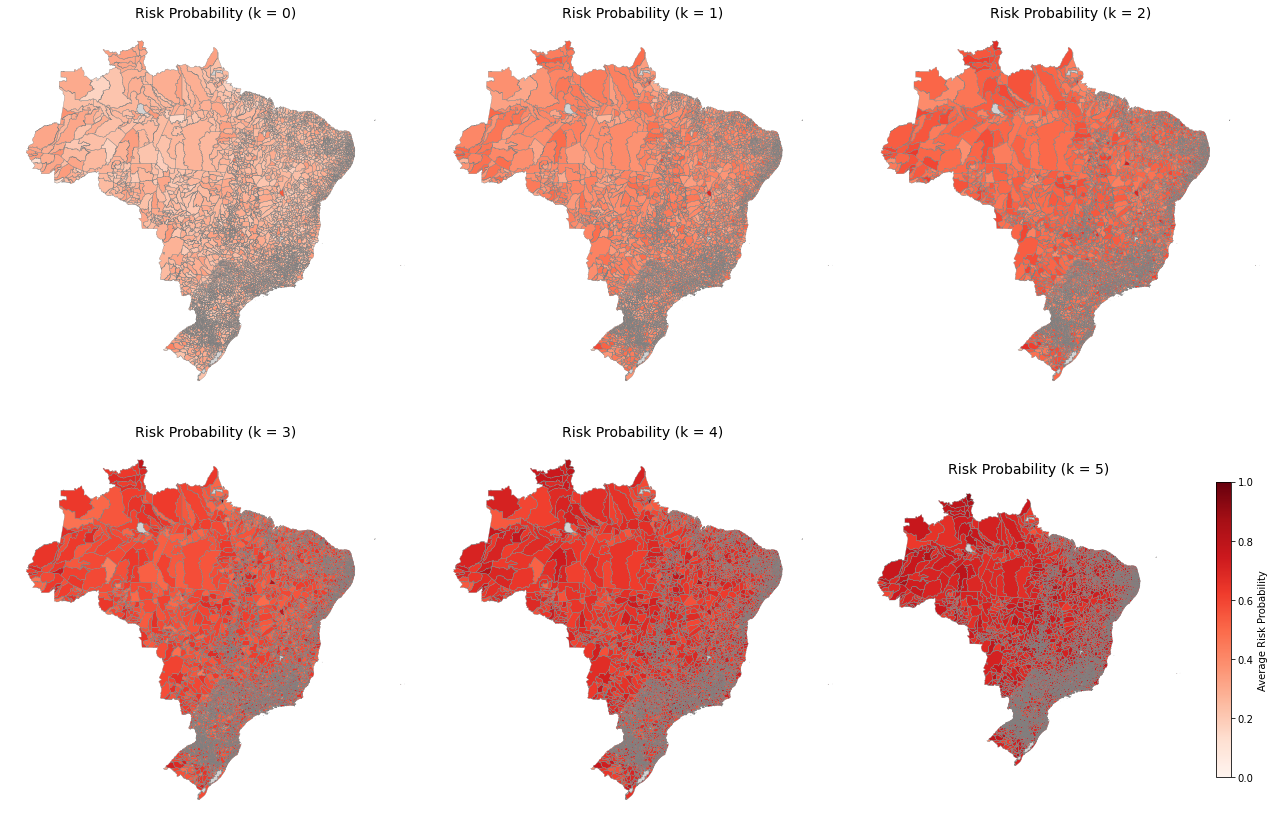

In [73]:
# ----------------------------
# 1. Prepare data
# ----------------------------
# Assuming you already have: muni, br_munis, dta1

# Convert types
br_munis['CD_MUN'] = br_munis['CD_MUN'].astype(int)
dta1['origin_city'] = dta1['origin_city'].astype(int)
muni['Código Município Completo'] = muni['Código Município Completo'].astype(int)

# Define list of k values
k_values = sorted(dta1['k'].unique())

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# ----------------------------
# 2. Loop over k values
# ----------------------------
for i, k in enumerate(k_values):
    dta_k = dta1[dta1['k'] == k]

    # Merge your city info with this subset
    #dta_map = pd.merge(
    #    muni,
    #    dta_k,
    #    left_on='Código Município Completo',
    #    right_on='origin_city',
    #    how='left'
    #)

    # Merge shapefile with risk data
    gdf = br_munis.merge(
        dta_k, #dta_map,
        left_on='CD_MUN',
        right_on= 'origin_city', #'Código Município Completo',
        how='left'
    )

    # Plot
    ax = axes[i]
    br_munis.boundary.plot(ax=ax, linewidth=0.3, color='grey')
    
    vmin = 0 #gdf['average_neighbour_level_probability'].min()
    vmax = 1 #gdf['average_neighbour_level_probability'].max()

    gdf.plot(
        column='average_neighbour_level_probability',
        cmap='Reds',
        ax=ax,
        vmin=vmin, vmax=vmax,
        legend=(i == len(k_values)-1),  # legend only on the last subplot
        legend_kwds={'label': "Average Risk Probability", 'shrink': 0.7},
        missing_kwds={"color": "lightgrey", "label": "No data"}
    )

    ax.set_title(f"Risk Probability (k = {k})", fontsize=14)
    ax.axis('off')

# ----------------------------
# 3. Layout & show
# ----------------------------
plt.tight_layout()
plt.show()


# Escolher uma semana e plotar a probabilidade de espalhamento considerando so os municípios que deram avisos

In [80]:
dta_week = df[df.year_week == '2025-14'][['co_ibge7', 'Aviso AESOP']]

In [85]:
dta1 = mob.groupby(['origin_city', 'k'])['average_neighbour_level_probability'].max().reset_index()

dta1['origin_city'] = dta1['origin_city'].astype(str)

muni['Código Município Completo'] = muni['Código Município Completo'].astype(str)

dta2 = dta1[dta1.k == 1]

dta_week['co_ibge7'] = dta_week['co_ibge7'].astype(str)

In [88]:
dta_week = pd.merge(dta_week, dta2, left_on='co_ibge7', right_on='origin_city', how='left')

In [92]:
dta_map_risk_k1 = pd.merge(muni, dta_week, left_on='Código Município Completo', right_on='co_ibge7', how='left')

In [97]:
dta3 = dta_map_risk_k1[dta_map_risk_k1['Aviso AESOP'] == 1].sort_values(by = 'average_neighbour_level_probability', ascending=False)


In [98]:
dta3

,UF,Nome_UF,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município,co_ibge6,co_ibge7,Aviso AESOP,origin_city,k,average_neighbour_level_probability
3247,33,Rio de Janeiro,6,Metropolitana do Rio de Janeiro,18,Rio de Janeiro,4904,3304904,São Gonçalo,330490,3304904,1.0,3304904,1.0,0.645933
2057,29,Bahia,5,Metropolitana de Salvador,21,Salvador,19207,2919207,Lauro de Freitas,291920,2919207,1.0,2919207,1.0,0.627451
3526,35,São Paulo,15,Metropolitana de São Paulo,57,Osasco,22505,3522505,Itapevi,352250,3522505,1.0,3522505,1.0,0.614286
1576,26,Pernambuco,5,Metropolitana de Recife,17,Recife,9600,2609600,Olinda,260960,2609600,1.0,2609600,1.0,0.607143
2171,29,Bahia,3,Centro Norte Baiano,12,Feira de Santana,28505,2928505,Santa Terezinha,292850,2928505,1.0,2928505,1.0,0.585714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,43,Rio Grande do Sul,1,Noroeste Rio-grandense,7,Santo Ângelo,6353,4306353,Dezesseis de Novembro,430635,4306353,1.0,4306353,1.0,0.254579
680,22,Piauí,4,Sudeste Piauiense,13,Picos,954,2200954,Aroeiras do Itaim,220095,2200954,1.0,2200954,1.0,0.250000
3553,35,São Paulo,2,Ribeirão Preto,14,Ribeirão Preto,25102,3525102,Jardinópolis,352510,3525102,1.0,3525102,1.0,0.245614
544,21,Maranhão,3,Centro Maranhense,11,Alto Mearim e Grajaú,5476,2105476,Jenipapo dos Vieiras,210547,2105476,1.0,2105476,1.0,0.236364
